In [26]:
import pandas as pd
import numpy as np
import random
import time
import datetime
from tqdm.auto import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt

import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup

from config import train_path, test_path, pretrained_bert_path, batch_size, learning_rate, eps, num_epochs, seed_val

In [2]:
df_train = pd.read_csv(train_path, index_col=0)

In [3]:
tokenizer = BertTokenizer.from_pretrained(pretrained_bert_path, do_lower_case=True)

In [4]:
sentences = df_train['sentence'].values
labels = df_train['label'].values

del df_train

In [5]:
max_len = 0

for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  196


In [6]:
len_all = []

for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    len_all.append(len(input_ids))

(array([782., 643., 176.,  49.,  11.,   4.,   1.,   2.,   0.,   1.]),
 array([  5. ,  24.1,  43.2,  62.3,  81.4, 100.5, 119.6, 138.7, 157.8,
        176.9, 196. ]),
 <BarContainer object of 10 artists>)

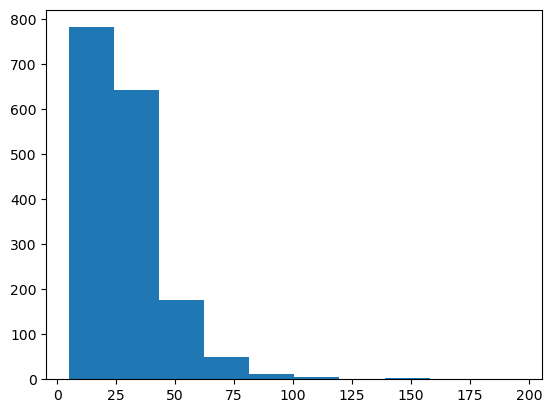

In [7]:
plt.hist(len_all)

In [8]:
long_sent = []

for sent in sentences:

    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    if len(input_ids) >= 128:
        long_sent.append(sent)

In [9]:
len(long_sent) / len(len_all)

0.002396644697423607

In [10]:
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
        sent,
        add_special_tokens = True,
        max_length = 128,
        pad_to_max_length = True,
        return_attention_mask = True,
        return_tensors = 'pt',
    )

    input_ids.append(encoded_dict['input_ids'])

    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [11]:
del sentences

In [20]:
dataset = TensorDataset(input_ids, attention_masks, labels)

In [21]:
def get_data_loaders(dataset, train_perc=0.8):
    train_size = int(train_perc * len(dataset))
    val_size = len(dataset) - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_dataloader = DataLoader(
        train_dataset,
        sampler = RandomSampler(train_dataset),
        batch_size = batch_size)

    validation_dataloader = DataLoader(
        val_dataset,
        sampler = SequentialSampler(val_dataset),
        batch_size = batch_size)

    return train_dataloader, validation_dataloader

In [14]:
dataset = TensorDataset(input_ids, attention_masks, labels)
#
# train_size = int(0.85 * len(dataset))
# val_size = len(dataset) - train_size
#
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
#
# print(f'{train_size} training samples')
# print(f'{val_size} validation samples')

1418 training samples
251 validation samples


In [19]:
# train_dataloader = DataLoader(
#     train_dataset,
#     sampler = RandomSampler(train_dataset),
#     batch_size = batch_size)
#
# validation_dataloader = DataLoader(
#     val_dataset,
#     sampler = SequentialSampler(val_dataset),
#     batch_size = batch_size)

In [16]:
model = BertForSequenceClassification.from_pretrained(
    pretrained_bert_path,
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at models/rubert_cased_L-12_H-768_A-12_pt_v1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

In [18]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [19]:
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=eps)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [22]:
train_dataloader, validation_dataloader = get_data_loaders(dataset)

epochs = num_epochs

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [23]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))

    return str(datetime.timedelta(seconds=elapsed_rounded))

In [24]:
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.mps.manual_seed(seed_val)

In [25]:
training_stats = []
total_t0 = time.time()
models = []

for epoch_i in range(0, epochs):
    print("")
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
    print('Training...')

    t0 = time.time()
    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 25 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            print(f'  Batch {step}  of  {len(train_dataloader)}.    Elapsed: {elapsed}.')

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        loss, logits = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels,
                             return_dict=False)

        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print("")
    print(f"  Average training loss: {avg_train_loss}")
    print(f"  Training epcoh took: {training_time}")

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            loss, logits = model(b_input_ids,
                                 token_type_ids=None,
                                 attention_mask=b_input_mask,
                                 labels=b_labels,
                                 return_dict=False)

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)

    print(f"  Accuracy: {avg_val_accuracy}")

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)

    print(f"  Validation Loss: {avg_val_loss}")
    print(f"  Validation took: {validation_time}")

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        })

    models.append(deepcopy(model))

    train_dataloader, validation_dataloader = get_data_loaders(dataset)

print("")
print("Training complete!")

print(f"Total training took {format_time(time.time()-total_t0)} (h:mm:ss)")


======== Epoch 1 / 5 ========
Training...
  Batch 25  of  84.    Elapsed: 0:00:32.
  Batch 50  of  84.    Elapsed: 0:01:03.
  Batch 75  of  84.    Elapsed: 0:01:34.

  Average training loss: 0.48611727108558017
  Training epcoh took: 0:01:46

Running Validation...
  Accuracy: 0.8592687074829932
  Validation Loss: 0.38593634963035583
  Validation took: 0:00:07

======== Epoch 2 / 5 ========
Training...
  Batch 25  of  84.    Elapsed: 0:00:31.
  Batch 50  of  84.    Elapsed: 0:01:02.
  Batch 75  of  84.    Elapsed: 0:01:34.

  Average training loss: 0.31319996763375546
  Training epcoh took: 0:01:45

Running Validation...
  Accuracy: 0.9430272108843537
  Validation Loss: 0.1703515499830246
  Validation took: 0:00:07

======== Epoch 3 / 5 ========
Training...
  Batch 25  of  84.    Elapsed: 0:00:33.
  Batch 50  of  84.    Elapsed: 0:01:05.
  Batch 75  of  84.    Elapsed: 0:01:36.

  Average training loss: 0.18410561398957812
  Training epcoh took: 0:01:47

Running Validation...
  Accurac

In [27]:
from collections import Counter

Counter([int(t) for t in labels])

Counter({0: 1340, 1: 329})

In [28]:
1340 / (329+1340)

0.8028759736369083

In [29]:
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

df_stats

Training Loss  Valid. Loss  Valid. Accur. Training Time Validation Time
epoch                                                                         
1           0.486117     0.385936       0.859269       0:01:46         0:00:07
2           0.313200     0.170352       0.943027       0:01:45         0:00:07
3           0.184106     0.282749       0.916241       0:01:47         0:00:07
4           0.154227     0.177078       0.948980       0:01:46         0:00:07
5           0.123616     0.064069       0.985119       0:02:00         0:00:08

In [30]:
model = models[-1]

del models

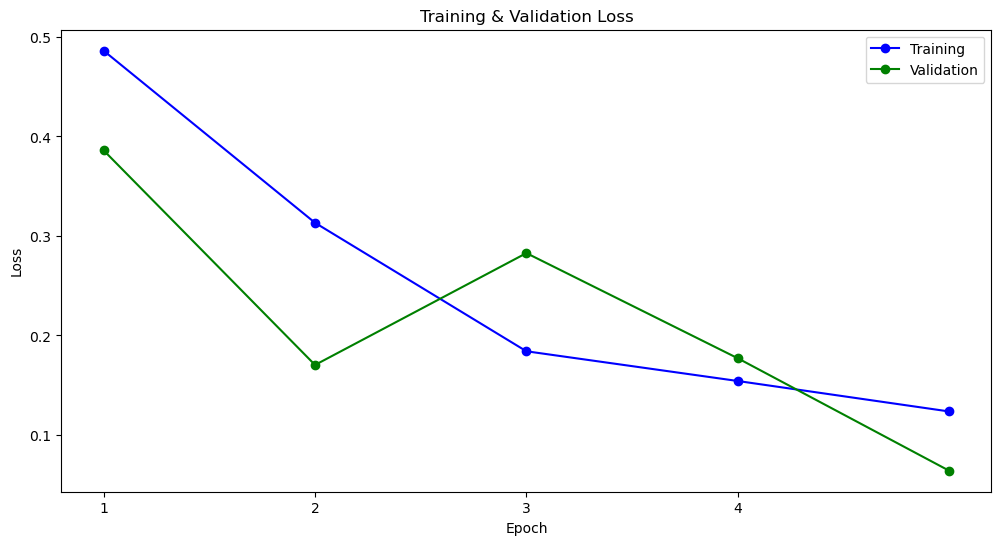

In [31]:
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [33]:
df_test = pd.read_csv(test_path, index_col=0)

print(f'Number of test sentences: {df_test.shape[0]}\n')

sentences = df_test['text'].values
idx = df_test['id'].values

input_ids = []
attention_masks = []
df_idx = []

for id_, sent in zip(idx, sentences):
    try:
        encoded_dict = tokenizer.encode_plus(
            sent,
            add_special_tokens = True,
            max_length = 100,
            pad_to_max_length = True,
            return_attention_mask = True,
            return_tensors = 'pt',
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
        df_idx.append(id_)
    except:
        continue

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

batch_size = 1

prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 10571



/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [34]:
model.eval()

predictions = []

for batch in tqdm(prediction_dataloader):
    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask,
                        return_dict=False)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    predictions.append(logits)

  0%|          | 0/10569 [00:00<?, ?it/s]

In [35]:
labels_pred = [np.argmax(pred, axis=1).flatten()[0] for pred in predictions]

label_true_idx = [i for i, l in enumerate(labels_pred) if l == 1]

labels = np.zeros(len(idx))

for id_ in label_true_idx:
    df_id = int(df_idx[id_])
    labels[df_id] = 1

In [36]:
df_test['label'] = pd.Series(labels, index=df_test.index)

df_test.to_csv('res/bert_pred.csv', encoding='utf-8', sep=';')

In [37]:
df_test[df_test['label'] == 1]['text'].sample().values[0]

'КИРОВ, 3 ноя - РИА Новости. Специалисты установят датчики непрерывного контроля выбросов на трубы предприятий по переработке опасных отходов и сделают получаемые данные доступными для любого гражданина онлайн, сообщил журналистам руководитель проектного офиса РосРАО (входит в госкорпорацию "РосАтом") Кирилл Шелученко.\n\nПо экспертным оценкам, в РФ образуется ежегодно около 350 тысяч тонн опасных отходов, из которых около 1,5% утилизируется\u200b\u200b\u200b. К промышленных отходам первого класса опасности относятся наносящие природе непоправимый ущерб, к отходам второго класса - такие отходы, после которых окружающая среда восстанавливается десятки лет. Предприятие госкорпорации "Росатом" ФГУП "РосРАО" официально стало федеральным оператором по обращению с промышленными отходами I и II классов опасности.\n"Мы хотим поставить на трубу непрерывный мониторинговый контроль, который будет доступен в сети всем желающим. Чтобы все видели по маркерным веществам, что никаких выбросов не проис

In [39]:
tokenizer.save_pretrained('res/bert_classifier/tokenizer/')

('res/bert_classifier/tokenizer/tokenizer_config.json',
 'res/bert_classifier/tokenizer/special_tokens_map.json',
 'res/bert_classifier/tokenizer/vocab.txt',
 'res/bert_classifier/tokenizer/added_tokens.json')

In [42]:
model.save_pretrained('res/bert_classifier/model/')